In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymongo
import pandas as pd

from numpy.polynomial.polynomial import polyfit

from constants import *

In [5]:
client = pymongo.MongoClient('localhost', 27017)
db = client.mineral_db

In [7]:
minerals_in_pgm = {}

for x in db.mineral_coll.find():
    mineral = x['mineral_name']
    
    try:
        pgms = x['pgm']
    except:
        continue
        
    for pgm in pgms:
        if pgm in minerals_in_pgm.keys():
            minerals_in_pgm[pgm].append(mineral)
        else:
            minerals_in_pgm[pgm] = [ mineral ]

In [8]:
pgm_attrs = pd.read_csv('data/2022_pgm_attributes.csv',
                        index_col='MODE'
                       ).transpose()
pgm_attrs.columns = [ s.lower() for s in pgm_attrs.columns ]

def get_attr(p, prop):
    if p[:-1] == 'p45':
        p = 'p45'
        
    if p[:-1] == 'p47':
        p = 'p47'
        
    return pgm_attrs[p][prop]


T_MIN = 'Temp (min) K'
T_MAX = 'Temp (max) K'
T_AVG = 'Temp (average) K'

P_MIN = 'P (min) log Pa'
P_MAX = 'P (max) log Pa'
P_AVG = 'P (average log Pa)'

In [9]:
symmetry_indices = {
    'amorphous': 1,
    'triclinic': 2,
    'monoclinic': 4,
    'orthorhombic': 8,
    'trigonal': 12,
    'tetragonal': 16,
    'hexagonal': 24,
    'cubic': 48
}

pgm_symmetry_indices = {}
pgm_populations = {}
n_minerals_in_pgm = {}

for p in minerals_in_pgm.keys():
    pgm_pop = { cs: 0 for cs in symmetry_indices.keys() }
    num_minerals = 0
    pgm_sym_ind = 0
    
    for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
        for crystal_system in x['crystal_systems']:
            if crystal_system in symmetry_indices.keys():
                pgm_pop[crystal_system] += 1
                num_minerals += 1
                pgm_sym_ind += symmetry_indices[crystal_system]
            
    try:
        pgm_symmetry_indices[p] = pgm_sym_ind / symmetry_indices['cubic'] / num_minerals
    except Exception as e:
        print(e)
        
    pgm_populations[p] = pgm_pop
    n_minerals_in_pgm[p] = num_minerals
    
pgm_symmetry_indices = { p: pgm_symmetry_indices[p] for p in sorted(pgm_symmetry_indices) }

float division by zero


In [12]:
def minerals_in_crit(CRIT):
    ret = {}
    
    for x in db.mineral_coll.find():
        mineral = x['mineral_name']
        
        try:
            pgms = x['pgm']
        except:
            continue
            

        for pgm in pgms:
            if pgm in ['Lunar', 'p02']:
                continue
                
            c = get_attr(pgm, CRIT)
            
            if c in ret.keys():
                ret[c].append(mineral)
            else:
                ret[c] = [ mineral ]
                
    return ret

In [11]:
minerals_in_crit(T_MIN)

asdf


{250: ['Abellaite',
  'Abellaite',
  'Abelsonite',
  'Abernathyite',
  'Abernathyite',
  'Abernathyite',
  'Abhurite',
  'Abhurite',
  'Abhurite',
  'Abuite',
  'Actinolite',
  'Acuminite',
  'Adamite',
  'Adamite',
  'Adamsite-(Y)',
  'Adanite',
  'Adanite',
  'Adelite',
  'Adelite',
  'Admontite',
  'Adolfpateraite',
  'Adolfpateraite',
  'Adolfpateraite',
  'Aegirine',
  'Aegirine',
  'Aegirine-augite',
  'Aegirine-augite',
  'Aerugite',
  'Aerugite',
  'Afmite',
  'Afmite',
  'Afmite',
  'Agaite',
  'Agaite',
  'Agardite-(Ce)',
  'Agardite-(Ce)',
  'Agardite-(La)',
  'Agardite-(La)',
  'Agardite-(Nd)',
  'Agardite-(Nd)',
  'Agardite-(Y)',
  'Agardite-(Y)',
  'Agricolaite',
  'Agricolaite',
  'Agrinierite',
  'Agrinierite',
  'Aheylite',
  'Aheylite',
  'Ahlfeldite',
  'Ahlfeldite',
  'Ajoite',
  'Akaganeite',
  'Akaganeite',
  'Akaganeite',
  'Akaganeite',
  'Akdalaite',
  'Akhtenskite',
  'Akopovaite',
  'Aksaite',
  'Alamosite',
  'Albertiniite',
  'Albite',
  'Albite',
  'Albite

In [13]:
def sym_ind(CRIT):
    crit_symmetry_indices = {}
    crit_populations = {}
    n_minerals_in_crit = {}
    
    mins_in_crit = minerals_in_crit(CRIT)
    
    for c in mins_in_crit.keys():
        crit_pop = { cs: 0 for cs in symmetry_indices.keys() }
        num_minerals = 0
        crit_sym_ind = 0

        for x in db.mineral_coll.find({ 'mineral_name': { '$in': mins_in_crit[c] } }):
            for crystal_system in x['crystal_systems']:
                if crystal_system in symmetry_indices.keys():
                    crit_pop[crystal_system] += 1
                    num_minerals += 1
                    crit_sym_ind += symmetry_indices[crystal_system]
                    
        try:
            crit_symmetry_indices[c] = crit_sym_ind / symmetry_indices['cubic'] / num_minerals
        except Exception as e:
            print(e)

        crit_populations[c] = crit_pop
        n_minerals_in_crit[c] = num_minerals

    crit_symmetry_indices = { crit: crit_symmetry_indices[crit] for crit in sorted(crit_symmetry_indices) }
    
    return crit_symmetry_indices, n_minerals_in_crit, crit_populations

In [14]:
crit_symmetry_indices, n_minerals_in_crit, crit_avg_populations = {}, {}, {}

for CRIT in [ T_MIN, T_MAX, P_MIN, P_MAX ]:
    crit_symmetry_indices[CRIT], n_minerals_in_crit[CRIT], crit_avg_populations[CRIT] = sym_ind(CRIT)

In [15]:
def plot_crit(CRIT, name, n_plots=1, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15, 10*n_plots))
    ordering = list(crit_symmetry_indices[CRIT].keys())
    l = len(ordering)//n_plots
    
    if n_plots == 1:
        ax = [ax]
    
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l
        
        num_name = f' ({(i+1)}/{n_plots})' if n_plots > 1 else ''
        crit_name = " ".join(CRIT.split()[:2])

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ crit_symmetry_indices[CRIT][p] for p in ordering[s:e] ])
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index by {crit_name}{num_name}', fontsize=FS_TITLE)
        plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_crit[CRIT][p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png')

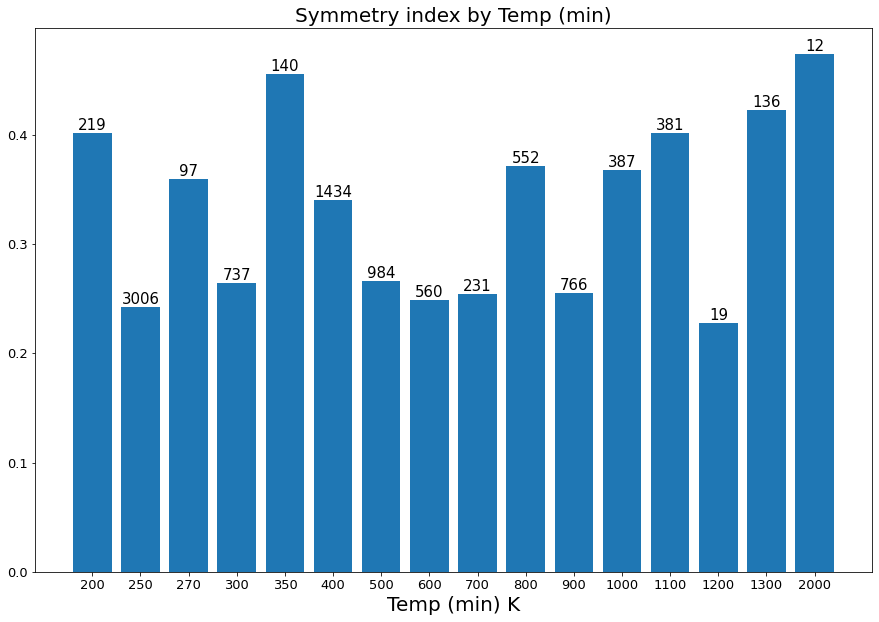

In [17]:
plot_crit(T_MIN, 'graph_tmin', nums=True)

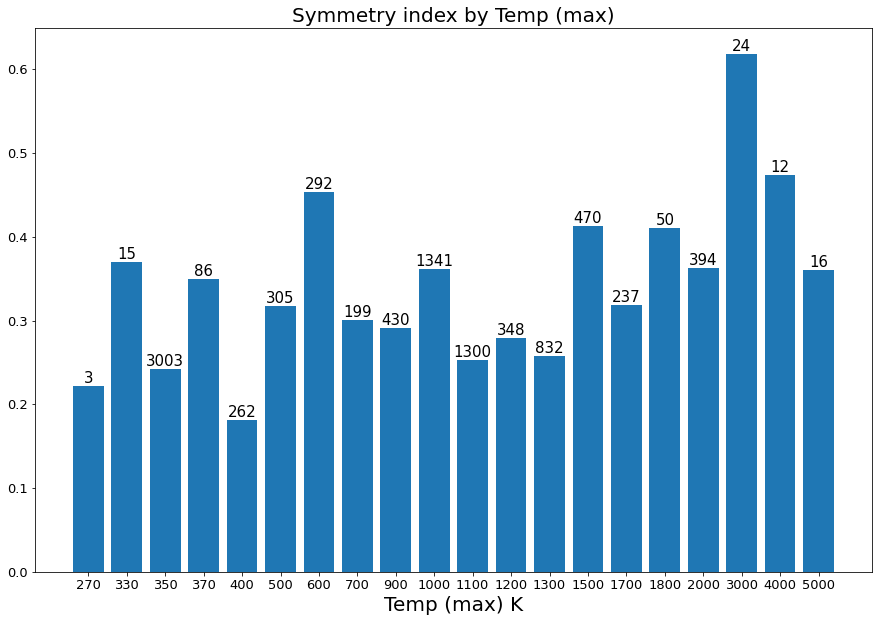

In [18]:
plot_crit(T_MAX, 'graph_tmax', nums=True)

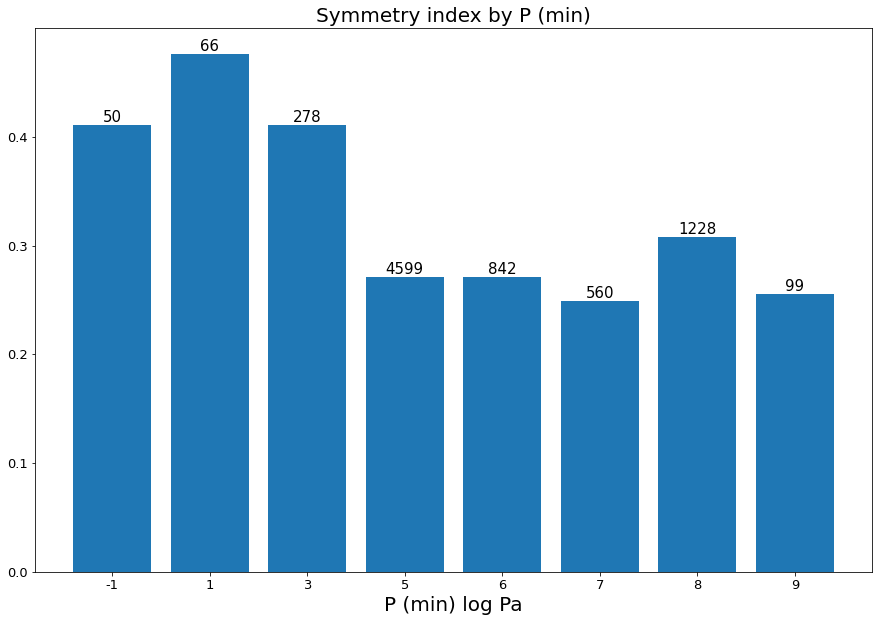

In [19]:
plot_crit(P_MIN, 'graph_pmin', nums=True)

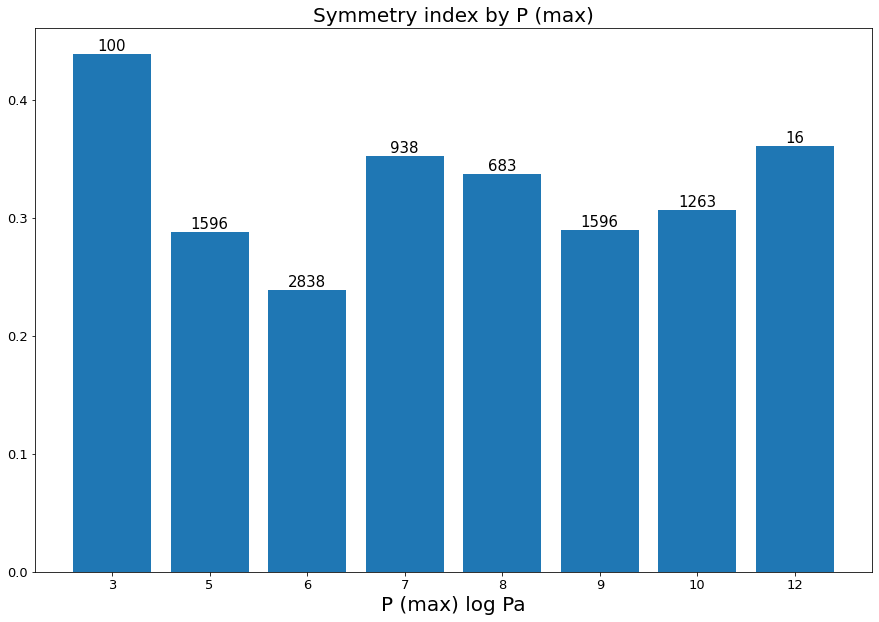

In [20]:
plot_crit(P_MAX, 'graph_pmax', nums=True)

In [21]:
def scatter_crit(CRIT, name, fit_q=False, start=None, end=None):
    if type(end) == int:
        end = -end
    
    plt.figure(figsize=(15, 10))
    ordering = list(crit_symmetry_indices[CRIT].keys())[start:end]
    syms = [ crit_symmetry_indices[CRIT][p] for p in ordering ]
    l = len(ordering)

    crit_name = " ".join(CRIT.split()[:2])
    if start is not None or end is not None:
        str_start = str(start) if start is not None else ''
        str_end = str(end) if end is not None else ''
        
        name += f'_exc_[{str_start}:{str_end}]'
    
    fit_lin = polyfit(ordering, syms, 1)
    poly_fit_lin = np.poly1d(fit_lin[::-1])
    
    y_avg = sum(syms)/len(syms)
    ss_res = sum([ (y-f)**2 for y, f in zip(syms, poly_fit_lin(ordering)) ])
    ss_tot = sum([ (y-y_avg)**2 for y in syms ])
    R2 = 1 - ss_res/ss_tot
    print(f'R^2 = {R2:.4f}')
    print(f'sqrt(R^2) = {np.sqrt(R2):.4f}')
    
    offset = max(ordering) / 50
    xs = np.linspace(min(ordering) - offset, max(ordering) + offset, 10000)
    plt.plot(xs, poly_fit_lin(xs))
    
    if fit_q:
        fit_quad = polyfit(ordering, syms, 2)
        plt.plot(xs, np.poly1d(fit_quad[::-1])(xs))
    
    plt.scatter(ordering, syms)
    
    plt.tick_params(axis='both', labelsize=FS_TICK)
    plt.title(f'Symmetry index by {crit_name}', fontsize=FS_TITLE)
    plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

    plt.savefig(f'results/{name}.png')

R^2 = 0.0185
sqrt(R^2) = 0.1361


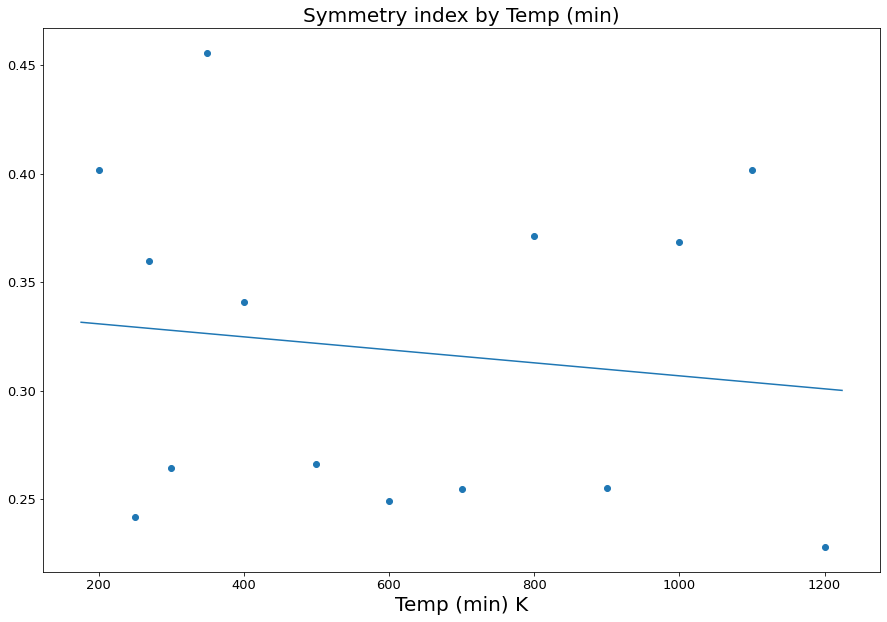

In [22]:
scatter_crit(T_MIN, 'graph_scatter_tmin', end=2)

R^2 = 0.0776
sqrt(R^2) = 0.2786


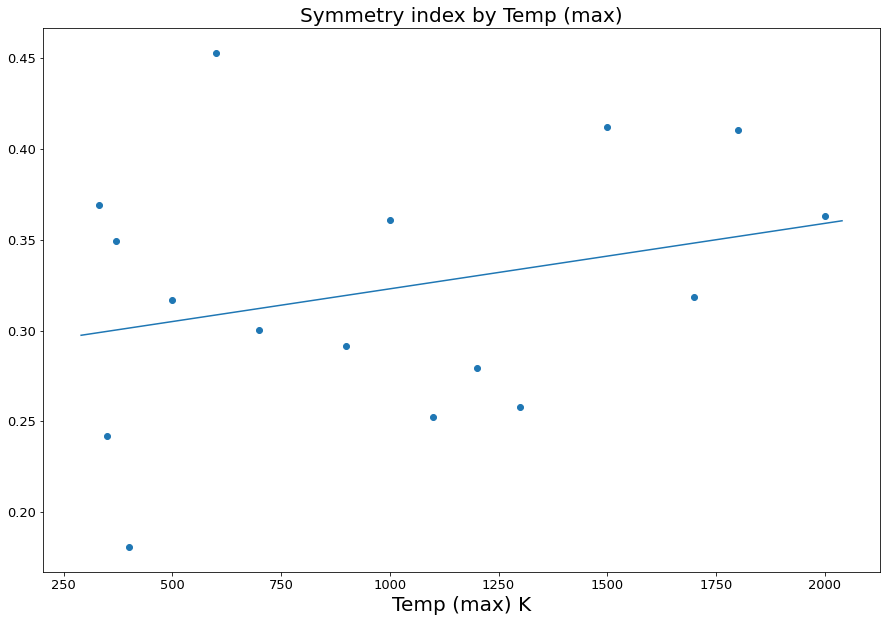

In [23]:
scatter_crit(T_MAX, 'graph_scatter_tmax', start=1, end=3)

R^2 = 0.6784
sqrt(R^2) = 0.8237


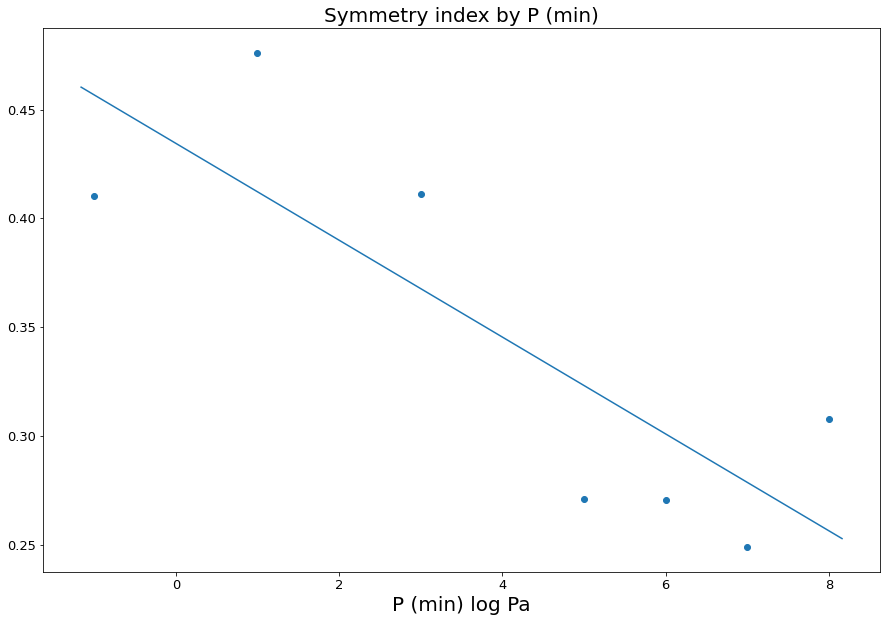

In [24]:
scatter_crit(P_MIN, 'graph_scatter_pmin', end=1)

R^2 = 0.7121
sqrt(R^2) = 0.8439


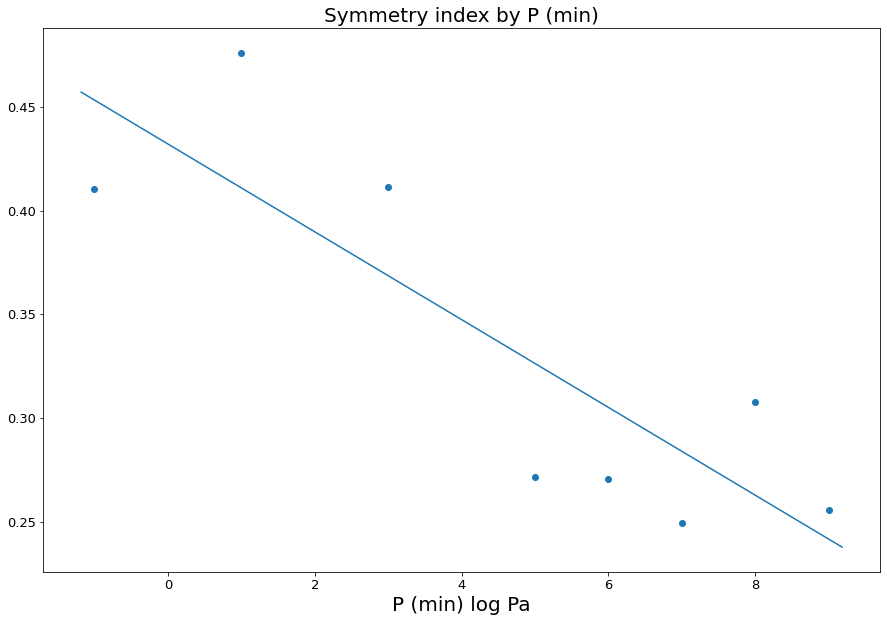

In [27]:
scatter_crit(P_MIN, 'graph_scatter_pmin')

R^2 = 0.0930
sqrt(R^2) = 0.3049


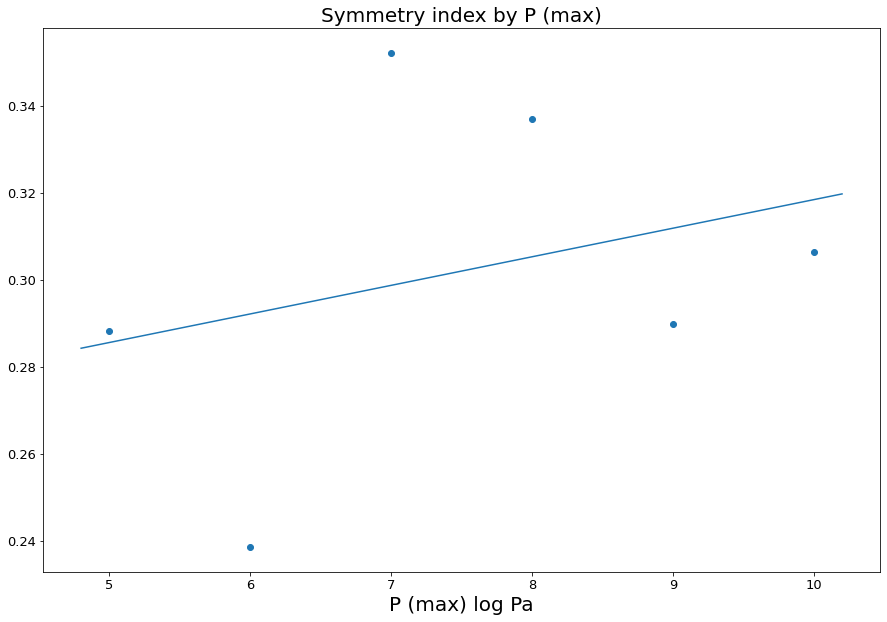

In [25]:
scatter_crit(P_MAX, 'graph_scatter_pmax', start=1, end=1)

R^2 = 0.3014
sqrt(R^2) = 0.5490


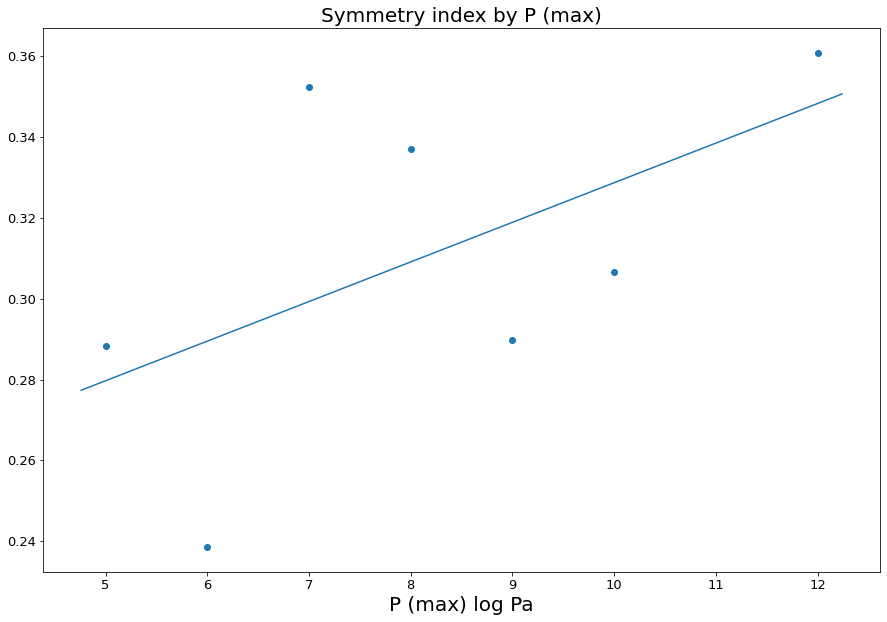

In [26]:
scatter_crit(P_MAX, 'graph_scatter_pmax', start=1, end=None)

R^2 = 0.0380
sqrt(R^2) = 0.1950


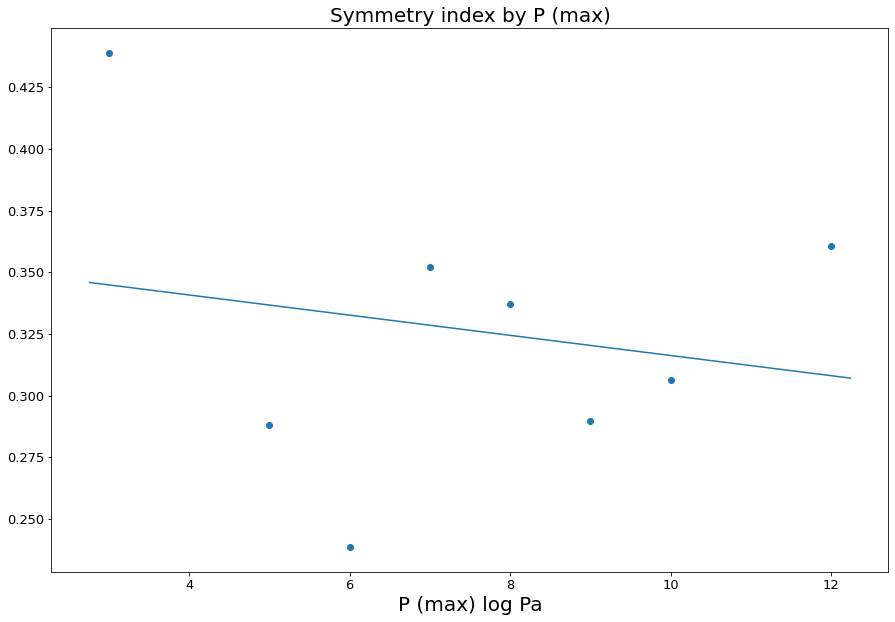

In [28]:
scatter_crit(P_MAX, 'graph_scatter_pmax')